In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm import tqdm
from torch import optim

import torch
import matplotlib.pyplot as plt
import numpy as np

In [5]:
batch_size = 32

train = MNIST('./', download=True,  train=True, transform=transforms.ToTensor())
test = MNIST('./', download=True,  train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [6]:
from ddpm import TimeEmb, DownSamplingBlock, ResBlock
from rl import EnergyModelMNIST, RLSampler
from torch import nn


model = EnergyModelMNIST(emb_channels=64, init_dim=96)
print(sum([p.numel() for p in model.parameters() if p.requires_grad]))

7026593


In [7]:
device = 'cuda'
# device = 'cpu'

loss_item=-929791.1875: 100%|██████████| 10/10 [5:52:27<00:00, 2114.79s/it]
<ipython-input-8-dff96dae9c2a>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


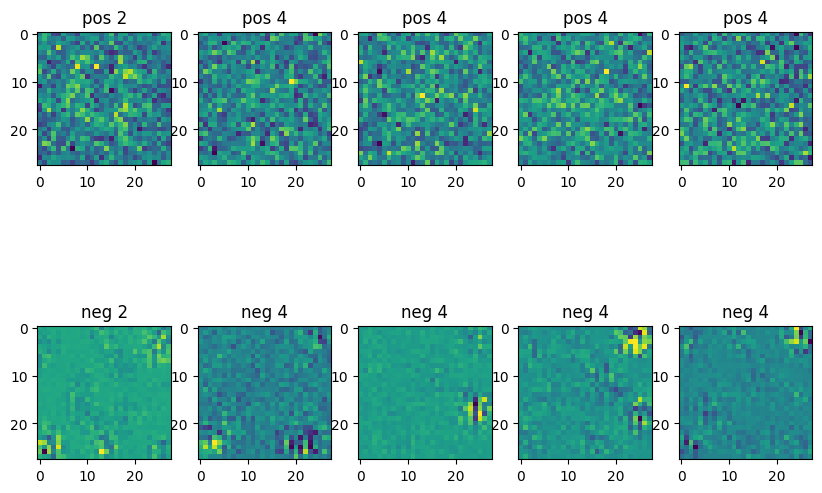

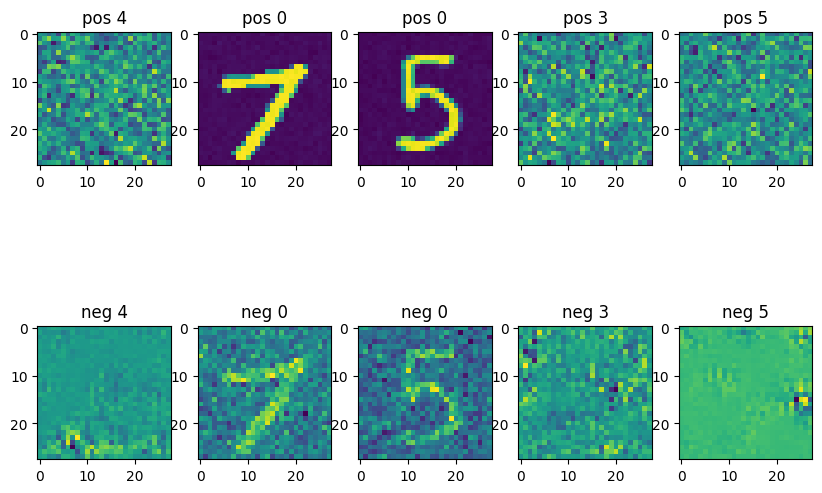

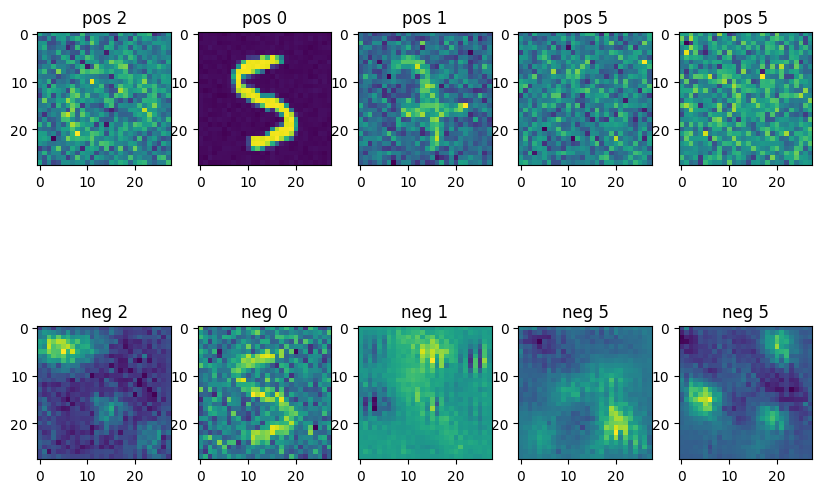

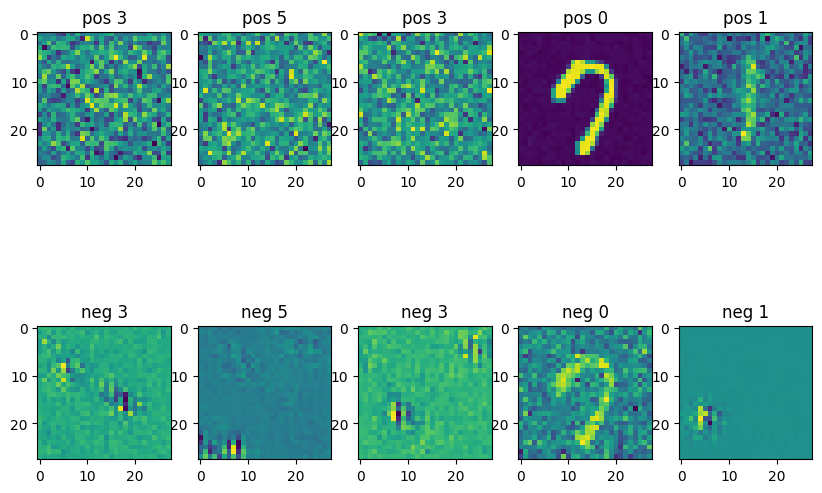

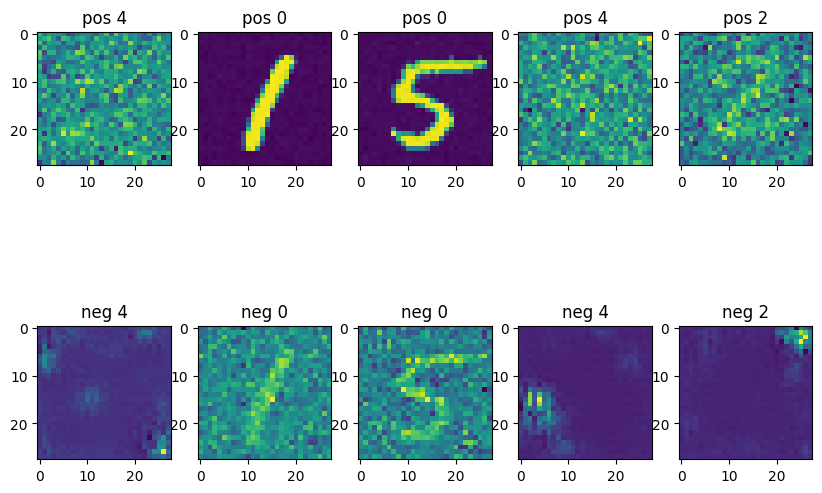

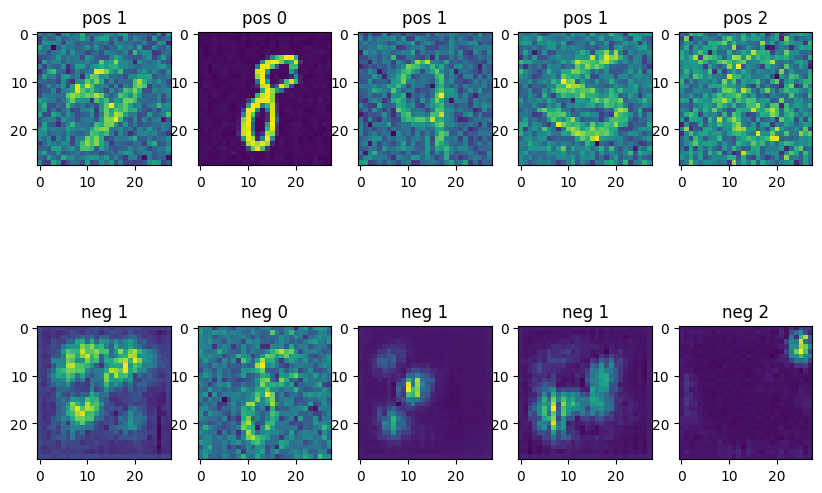

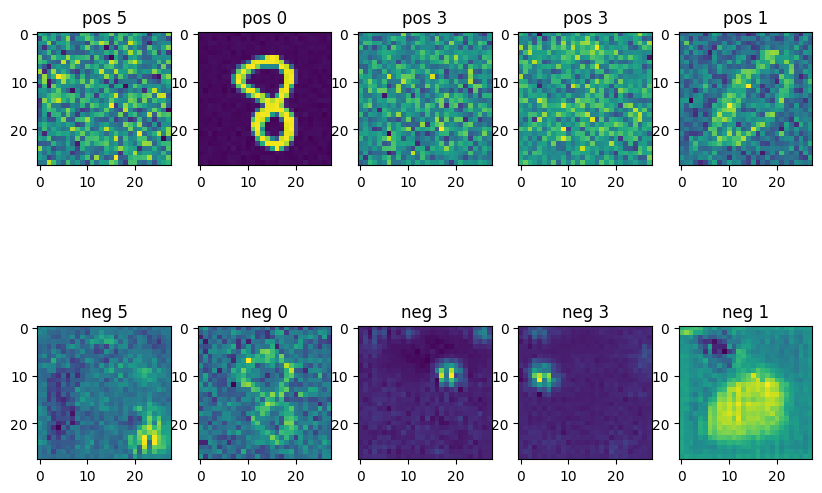

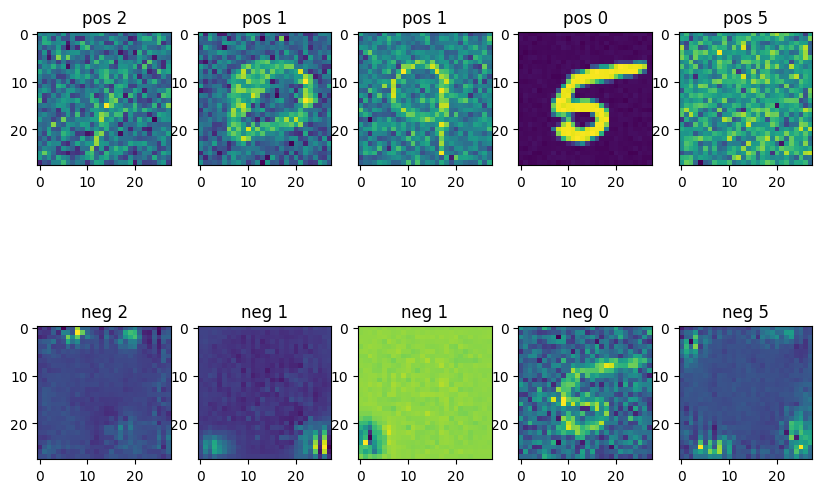

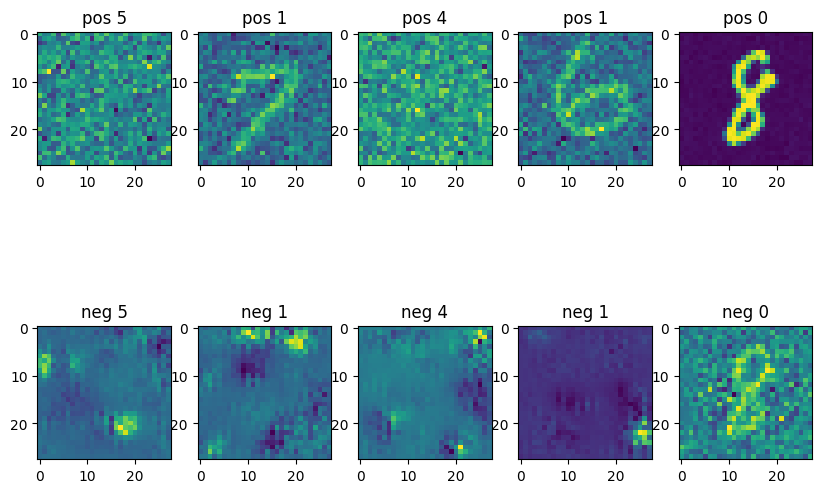

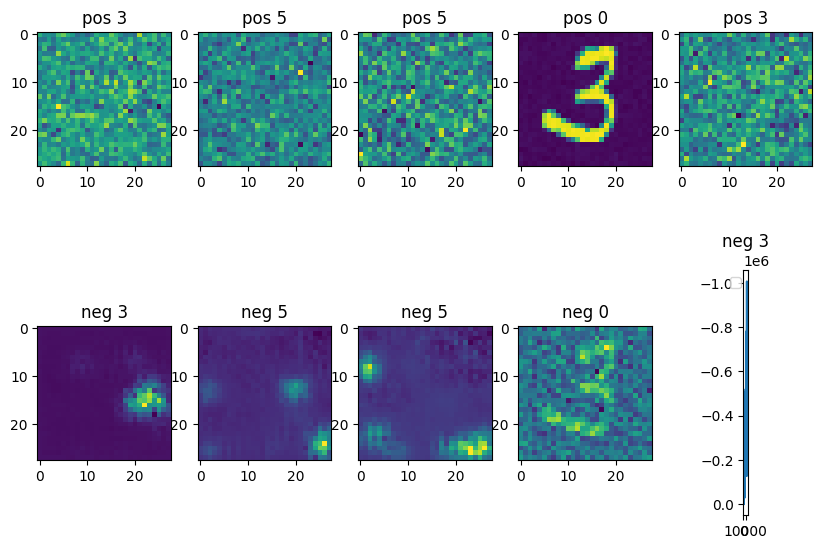

In [8]:
N_EPOCHS = 10

dif_model = RLSampler(model, device=device)

opt = optim.Adam(model.parameters(), lr=5e-5)
losses = []

for ep in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        opt.zero_grad()
        t = torch.randint(0, dif_model.n_steps, (data.shape[0],), device=device)
        x_pos, x_neg = dif_model.q_sample_pairs(data, t)
        x_neg = dif_model.p_sample_langevin(x_neg, t)
        loss = dif_model.training_losses(x_pos, x_neg, t)
        loss.backward()
        opt.step()
        loss_item = loss.detach().cpu().item()
        losses.append(loss_item)

    sampled_ind = np.random.choice(len(t.detach().cpu().numpy()), 5, replace=False)
    fig, axs = plt.subplots(2, 5, figsize=(10, 7))
    for i, ind in enumerate(sampled_ind):
      axs[0][i].imshow(x_pos[ind][0].detach().cpu().numpy())
      axs[0][i].set_title(f'pos {t[ind]}')
      axs[1][i].imshow(x_neg[ind][0].detach().cpu().numpy())
      axs[1][i].set_title(f'neg {t[ind]}')
    plt.savefig(f'ep_{ep}.png', dpi=300)

    pbar.set_description(f'{loss_item=}')

plt.plot(losses)
plt.legend();

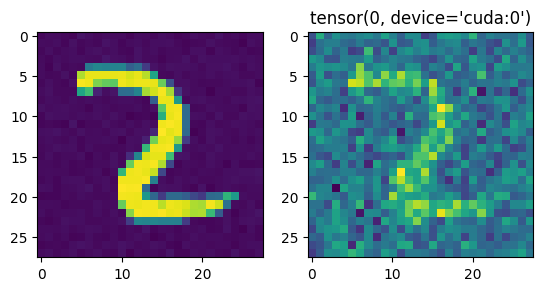

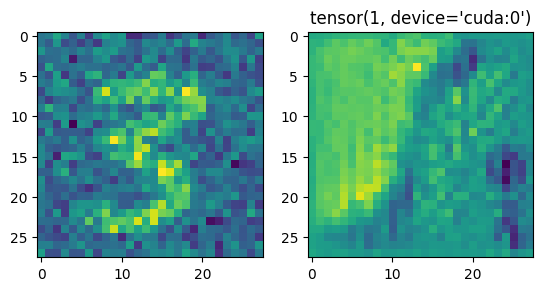

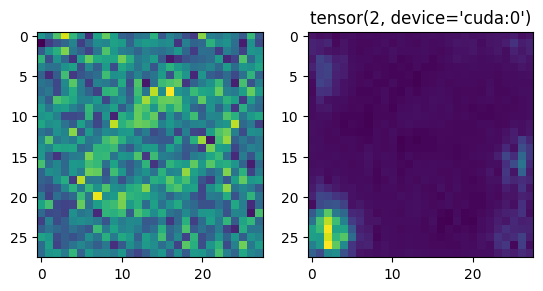

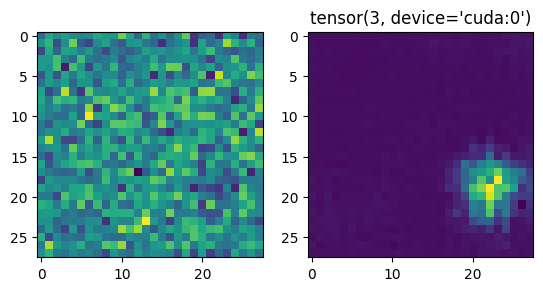

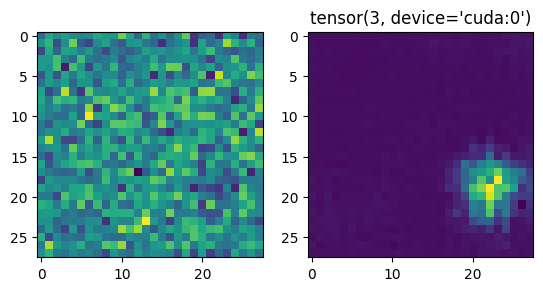

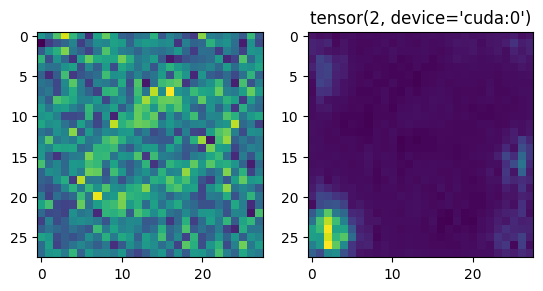

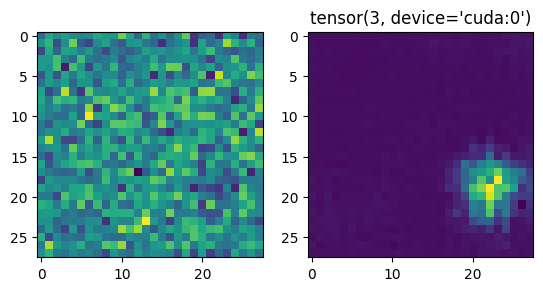

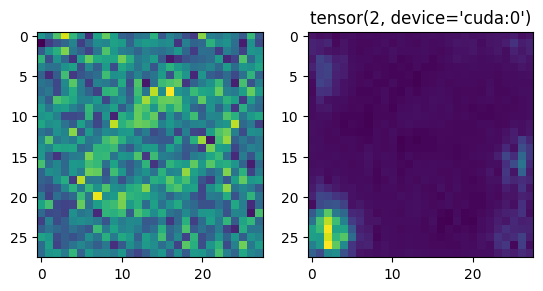

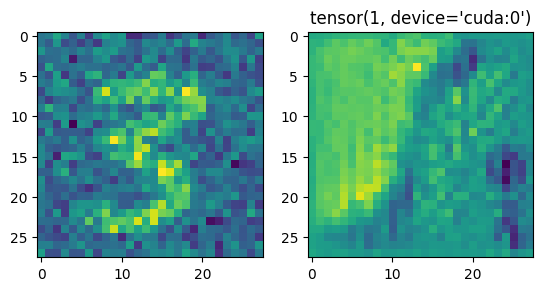

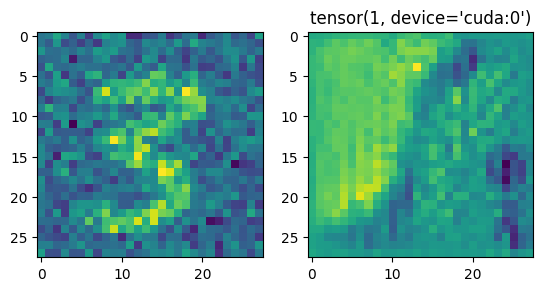

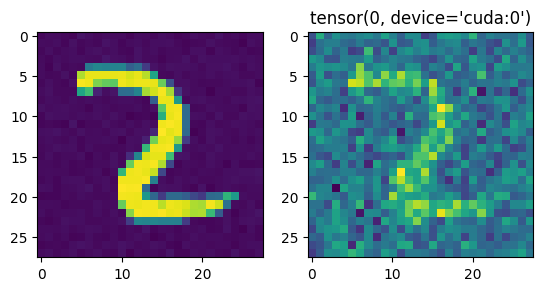

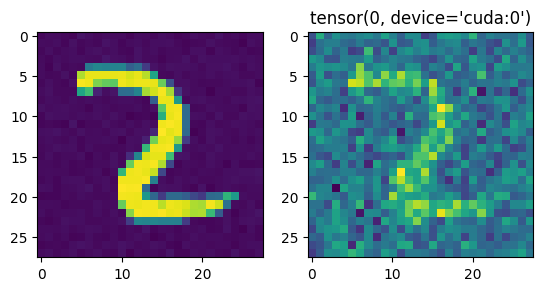

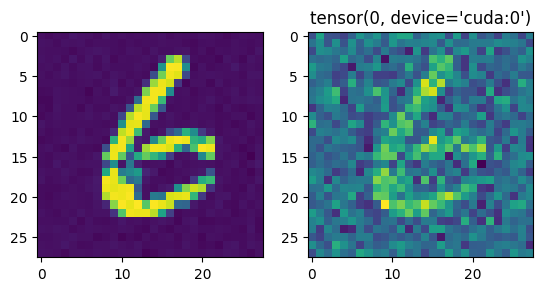

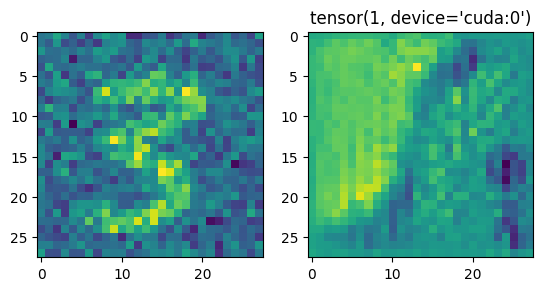

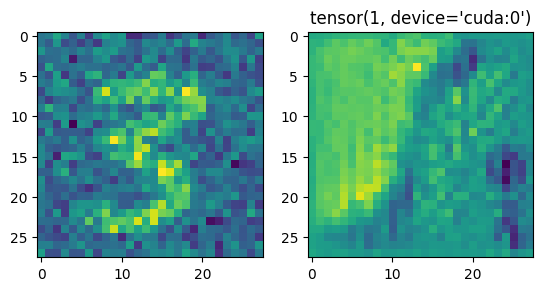

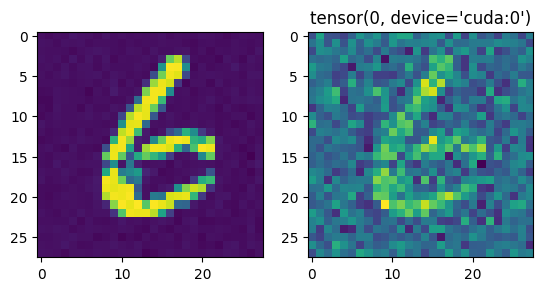

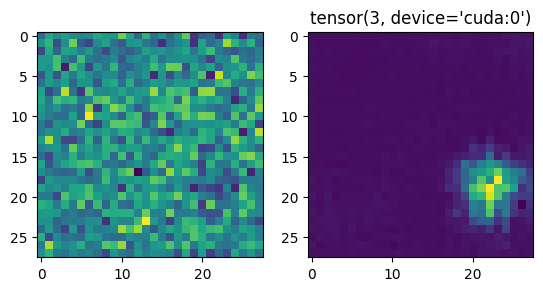

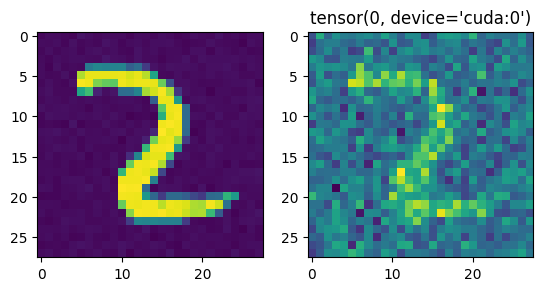

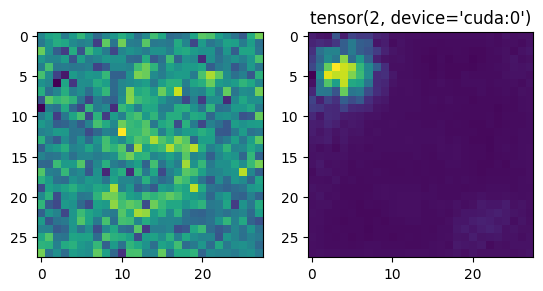

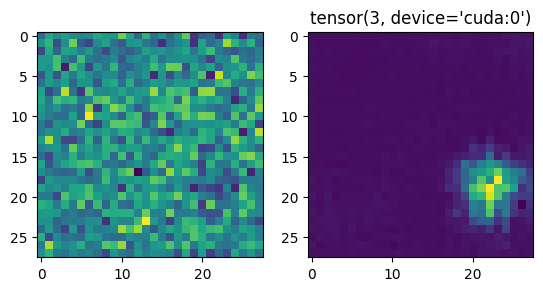

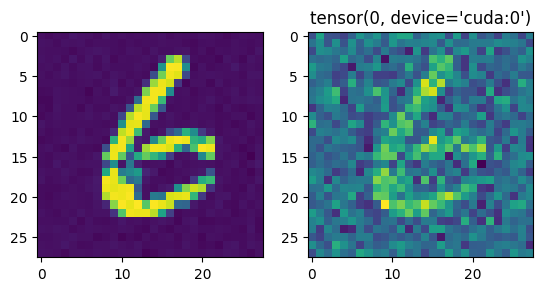

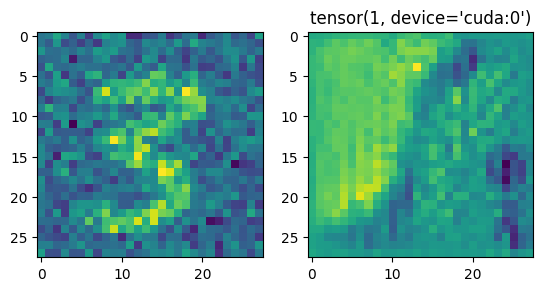

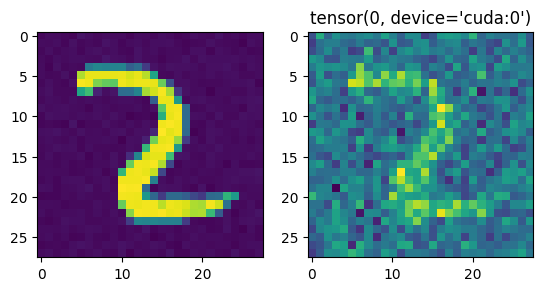

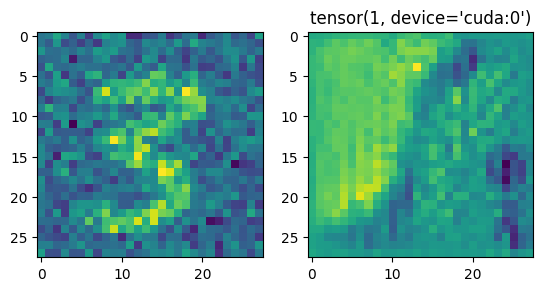

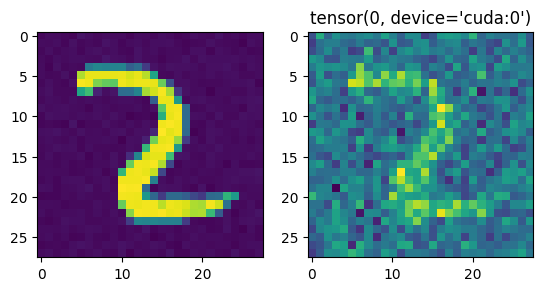

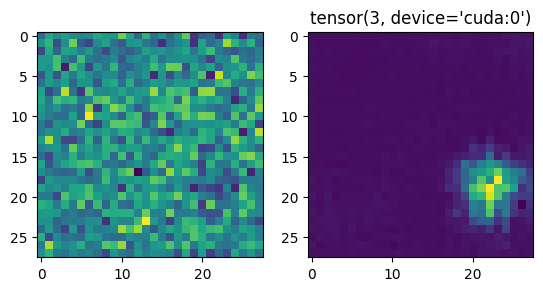

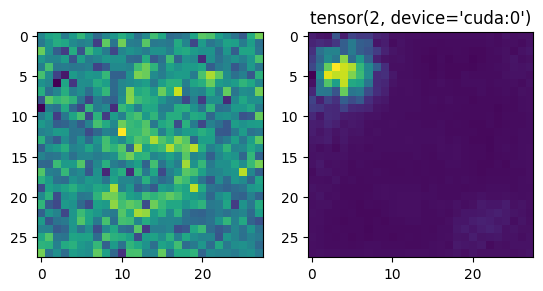

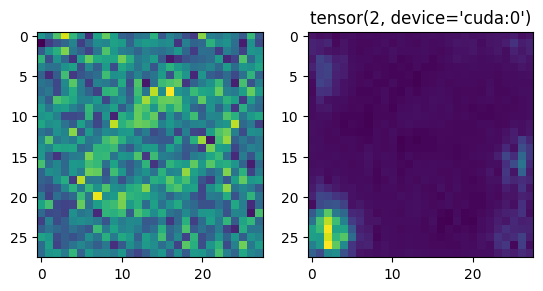

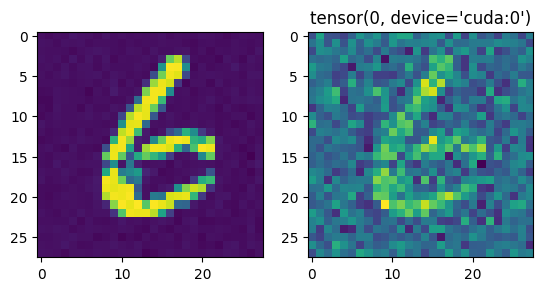

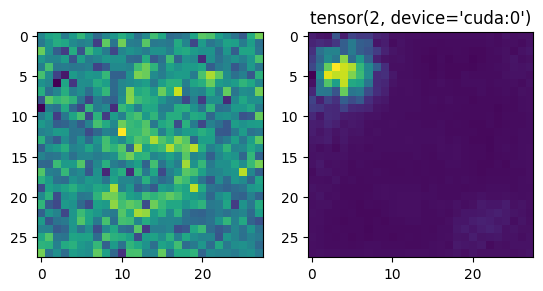

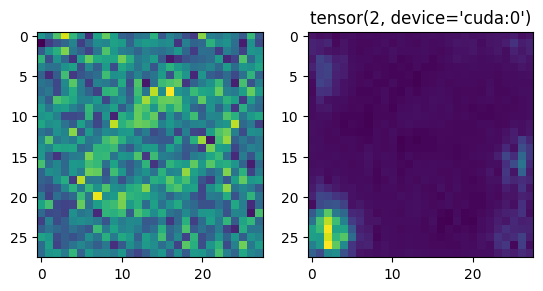

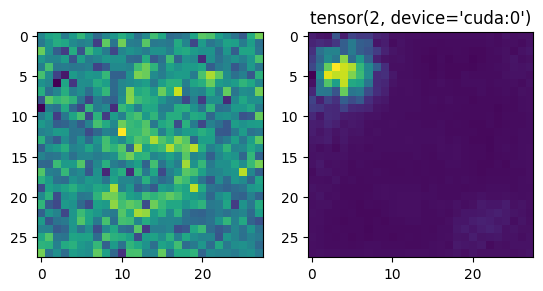

In [9]:
for i in t:
  f, axs = plt.subplots(1, 2)
  plt.title(t[i])
  axs[0].imshow(x_pos[i][0].detach().cpu().numpy())
  axs[1].imshow(x_neg[i][0].detach().cpu().numpy())
  plt.show()


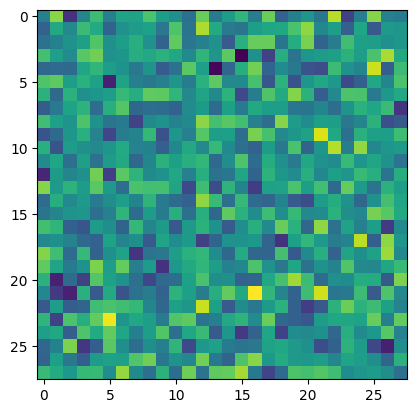

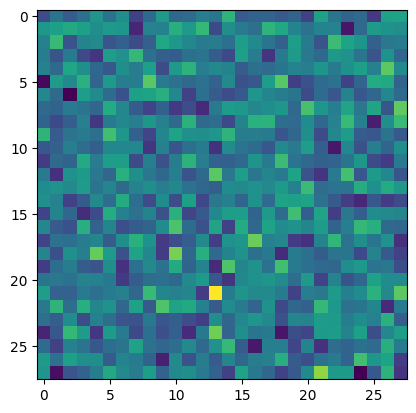

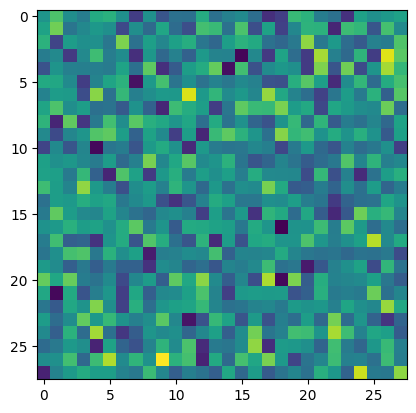

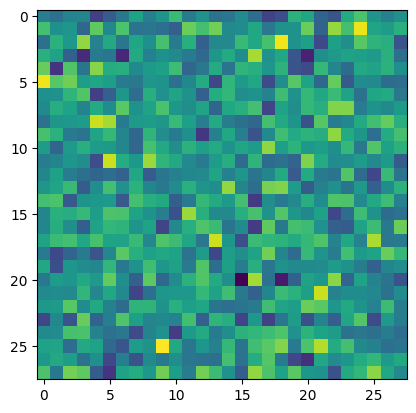

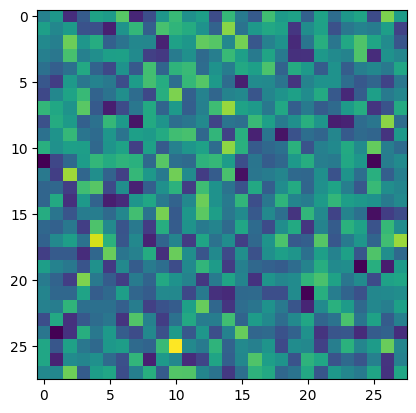

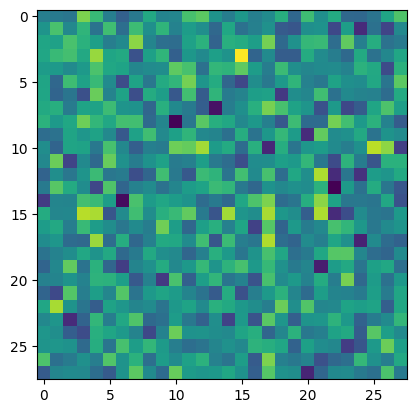

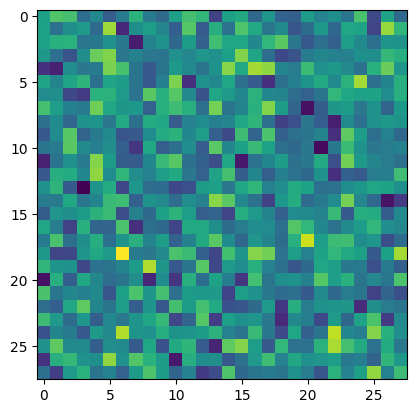

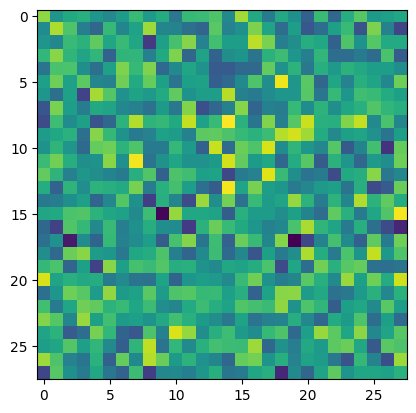

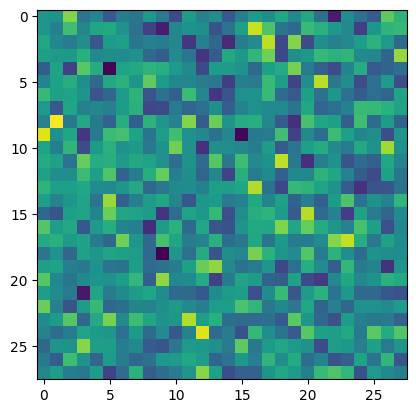

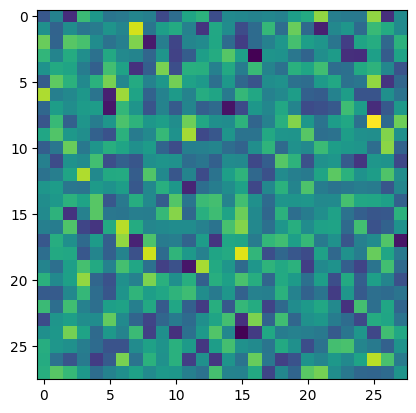

In [10]:
n_samples = 10



noise = torch.randn([n_samples, 1, 28, 28], device=device)
x_neg_seq = dif_model.p_sample_given_xt(noise)

x_neg_seq = x_neg_seq.detach().cpu().numpy()
for i in range(n_samples):
  plt.imshow(x_neg_seq[-1][i][0])
  plt.show()